In [49]:
# CIS 508 - Arnab Chatterjee
# ML_Individual_Assignment 1

import numpy as np # linear algebra
import pandas as pd # data processing

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [51]:
# Import all libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score


In [53]:
# Load the datasets
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')


In [54]:
# The train.shape and test.shape attributes provide a tuple representing the number of rows and columns in each dataset, 
# helping to verify the data's structure before further analysis or model training.
print(f'Training data shape: {train.shape}')
print(f'Test data shape: {test.shape}')


Training data shape: (76020, 371)
Test data shape: (75818, 370)


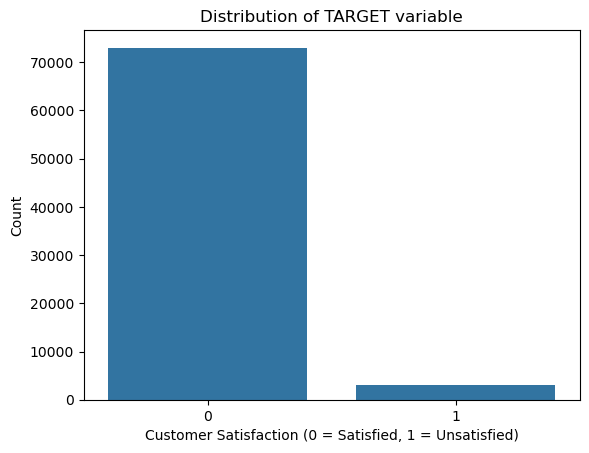

In [55]:
# Plot distribution of the target variable
sns.countplot(x='TARGET', data=train)
plt.title('Distribution of TARGET variable')
plt.xlabel('Customer Satisfaction (0 = Satisfied, 1 = Unsatisfied)')
plt.ylabel('Count')
plt.show()


The dataset is highly imbalanced: Satisfied customers (TARGET=0): ~73,000 instances. Unsatisfied customers (TARGET=1): ~3,000 instances.

In [59]:
# Find the variables with zero variance
zero_variance = [col for col in train.columns if train[col].std() == 0]
print(f'Variables with zero variance: {zero_variance}')

Variables with zero variance: ['ind_var2_0', 'ind_var2', 'ind_var27_0', 'ind_var28_0', 'ind_var28', 'ind_var27', 'ind_var41', 'ind_var46_0', 'ind_var46', 'num_var27_0', 'num_var28_0', 'num_var28', 'num_var27', 'num_var41', 'num_var46_0', 'num_var46', 'saldo_var28', 'saldo_var27', 'saldo_var41', 'saldo_var46', 'imp_amort_var18_hace3', 'imp_amort_var34_hace3', 'imp_reemb_var13_hace3', 'imp_reemb_var33_hace3', 'imp_trasp_var17_out_hace3', 'imp_trasp_var33_out_hace3', 'num_var2_0_ult1', 'num_var2_ult1', 'num_reemb_var13_hace3', 'num_reemb_var33_hace3', 'num_trasp_var17_out_hace3', 'num_trasp_var33_out_hace3', 'saldo_var2_ult1', 'saldo_medio_var13_medio_hace3']


Variables with zero variance do not provide any discriminatory power and can be removed.

In [61]:
# Calculat the missing value percentages
missing_percent = train.isnull().mean() * 100
high_missing = missing_percent[missing_percent > 50].index.tolist()
print(f'Variables with >50% missing values: {high_missing}')


Variables with >50% missing values: []


In [63]:
test.isnull().sum()

ID                         0
var3                       0
var15                      0
imp_ent_var16_ult1         0
imp_op_var39_comer_ult1    0
                          ..
saldo_medio_var44_hace2    0
saldo_medio_var44_hace3    0
saldo_medio_var44_ult1     0
saldo_medio_var44_ult3     0
var38                      0
Length: 370, dtype: int64

In [65]:
# Compute the correlation matrix
corr_matrix = train.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features with correlation greater than 0.99
high_corr = [column for column in upper.columns if any(upper[column] > 0.99)]
print(f'Highly correlated variables: {high_corr}')

Highly correlated variables: ['imp_op_var39_efect_ult1', 'imp_op_var39_efect_ult3', 'imp_op_var39_ult1', 'ind_var13_largo', 'ind_var13_medio', 'ind_var18', 'ind_var26', 'ind_var25', 'ind_var29_0', 'ind_var29', 'ind_var32', 'ind_var34', 'ind_var37', 'ind_var40_0', 'ind_var40', 'ind_var39', 'num_var1_0', 'num_var1', 'num_var5', 'num_var6_0', 'num_var6', 'num_var8_0', 'num_var8', 'num_var12', 'num_var13_corto_0', 'num_var13_corto', 'num_var13_medio_0', 'num_var13_medio', 'num_var18_0', 'num_var18', 'num_var20_0', 'num_var20', 'num_var24_0', 'num_var24', 'num_var26', 'num_var25', 'num_op_var39_hace2', 'num_var29_0', 'num_var29', 'num_var32', 'num_var34_0', 'num_var34', 'num_var37', 'num_var40_0', 'num_var40', 'num_var39', 'num_var44_0', 'num_var44', 'saldo_var18', 'saldo_var24', 'saldo_var29', 'delta_imp_amort_var18_1y3', 'delta_imp_amort_var34_1y3', 'delta_num_aport_var13_1y3', 'delta_num_aport_var17_1y3', 'delta_num_aport_var33_1y3', 'delta_num_compra_var44_1y3', 'delta_num_reemb_var13_1

Highly correlated variables may introduce redundancy. Removing one of the correlated pairs can reduce multicollinearity.

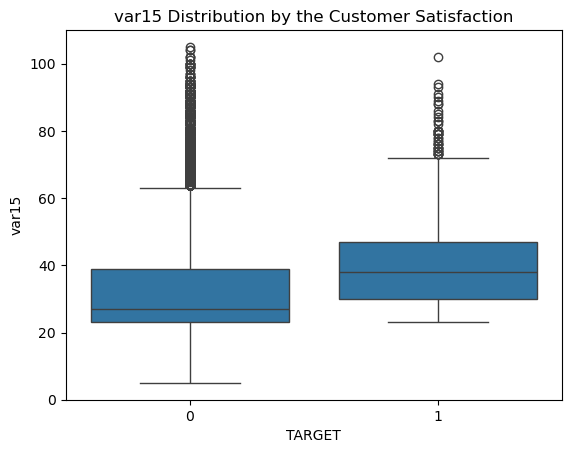

In [66]:
# Plot the distribution of var15 by TARGET to visualize its relationship with customer satisfaction.
sns.boxplot(x='TARGET', y='var15', data=train)
plt.title('var15 Distribution by the Customer Satisfaction')
plt.show()

There's a noticeable difference in var15 distribution between satisfied and unsatisfied customers.

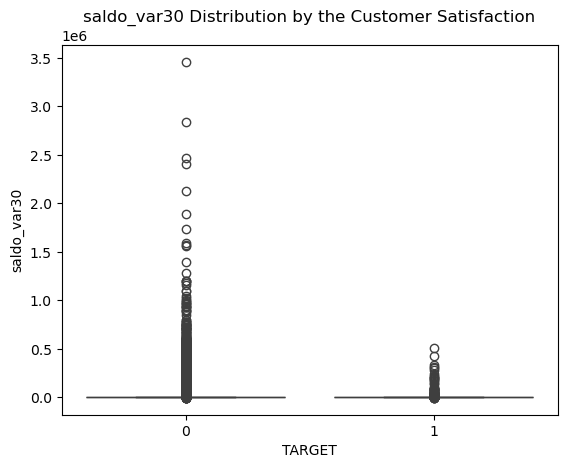

In [69]:
# Plot the distribution of saldo_var30 by TARGET to examine it's association with customer satisfaction.
sns.boxplot(x='TARGET', y='saldo_var30', data=train)
plt.title('saldo_var30 Distribution by the Customer Satisfaction')
plt.show()

Unsatisfied customers tend to have higher saldo_var30 values.

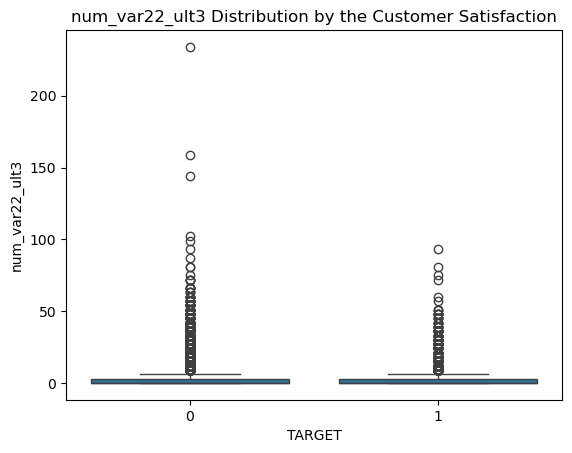

In [71]:
# Plot the distribution of num_var22_ult3 by TARGET to analyze it's relationship with customer satisfaction.
sns.boxplot(x='TARGET', y='num_var22_ult3', data=train)
plt.title('num_var22_ult3 Distribution by the Customer Satisfaction')
plt.show()

Differences in transaction counts over the last three months between satisfied and unsatisfied customers.

In [73]:
# Preparing the data
X = train.drop(['TARGET', 'ID'], axis=1)
y = train['TARGET']

# Spliting into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Baseline model
clf_baseline = DecisionTreeClassifier(random_state=42)
clf_baseline.fit(X_train, y_train)

# Predictions
y_pred_baseline = clf_baseline.predict_proba(X_val)[:,1]

# Evaluation
auc_baseline = roc_auc_score(y_val, y_pred_baseline)
print(f'Baseline Model AUC: {auc_baseline:.4f}')

Baseline Model AUC: 0.5747


In [75]:
# Model with limited depth
clf_depth = DecisionTreeClassifier(max_depth=5, random_state=42)
clf_depth.fit(X_train, y_train)

# Predictions
y_pred_depth = clf_depth.predict_proba(X_val)[:,1]

# Evaluate
auc_depth = roc_auc_score(y_val, y_pred_depth)
print(f'Model with max_depth=5 AUC: {auc_depth:.4f}')

Model with max_depth=5 AUC: 0.8183


In [77]:
# Model using entropy criterion
clf_entropy = DecisionTreeClassifier(criterion='entropy', random_state=42)
clf_entropy.fit(X_train, y_train)

# Predictions
y_pred_entropy = clf_entropy.predict_proba(X_val)[:,1]

# Evaluate
auc_entropy = roc_auc_score(y_val, y_pred_entropy)
print(f'Model with criterion="entropy" AUC: {auc_entropy:.4f}')

Model with criterion="entropy" AUC: 0.5711


In [79]:
# Model with limited leaf nodes
clf_leaf = DecisionTreeClassifier(max_leaf_nodes=10, random_state=42)
clf_leaf.fit(X_train, y_train)

# Predictions
y_pred_leaf = clf_leaf.predict_proba(X_val)[:,1]

# Evaluate
auc_leaf = roc_auc_score(y_val, y_pred_leaf)
print(f'Model with max_leaf_nodes=10 AUC: {auc_leaf:.4f}')

Model with max_leaf_nodes=10 AUC: 0.8054


In [81]:
# Trains the model and returns the AUC score on the validation set to evaluate performance.
def train_and_evaluate(model, X_train, y_train, X_val, y_val):
    # Train the model
    model.fit(X_train, y_train)
    # Predict probabilities
    y_pred = model.predict_proba(X_val)[:,1]
    # Calculate AUC
    auc = roc_auc_score(y_val, y_pred)
    return auc

In [87]:
# Make predictions on the test set
test_predictions = clf_depth.predict_proba(test.drop('ID', axis=1))[:,1]

# Prepare submission file
submission = pd.DataFrame({'ID': test['ID'], 'TARGET': test_predictions})
submission.to_csv('_ARNAB_submission.csv', index=False)
